In [60]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [61]:
with open('ei_intermediate_file_paths.json') as file_path_file:
    file_paths = json.load(file_path_file)


SI_PREDS_INPUT_PATH = file_paths.get("smoke_impact_model_predictions.csv")
NOAA_BLS_MERGED_INPUT_PATH = file_paths.get("stage2_fs_merged_output.csv")
EI_MODEL_INPUT_PATH = file_paths.get("ei_model_output")

EI_PREDS_OUTPUT_PATH = file_paths.get("economic_impact_model_predictions.csv")

In [62]:
# Load dataset
si_preds_df = pd.read_csv(SI_PREDS_INPUT_PATH)

noaa_bls_historical_df = pd.read_csv(NOAA_BLS_MERGED_INPUT_PATH)

In [63]:
print(si_preds_df.head(5))

print(si_preds_df.columns)

   year  predicted_total_acres_burned  predicted_avg_distance  \
0  2021                  2.351687e+06              359.010931   
1  2022                  2.351687e+06              359.010931   
2  2023                  2.351687e+06              359.010931   
3  2024                  2.351687e+06              359.010931   
4  2025                  2.351687e+06              359.010931   

   total_acres_burned_normalized  distance_normalized  \
0                       0.483929             0.552325   
1                       0.483929             0.552325   
2                       0.483929             0.552325   
3                       0.483929             0.552325   
4                       0.483929             0.552325   

   total_acres_burned_weighted  distance_weighted  predicted_smoke_impact  
0                     0.483929           0.552325               35.208975  
1                     0.483929           0.552325               35.208975  
2                     0.483929        

In [64]:
print(noaa_bls_historical_df.head(5))

print(noaa_bls_historical_df.columns)

         date    bls_date  bls_curr_sae_hrs  bls_curr_laus_labor_force  \
0  2009-09-01  2009-09-01              36.8                   421301.0   
1  2009-10-01  2009-10-01              36.7                   422913.0   
2  2010-05-01  2010-05-01              38.0                   415895.0   
3  2010-06-01  2010-06-01              37.9                   421034.0   
4  2010-07-01  2010-07-01              37.4                   423239.0   

   bls_curr_laus_unemployment_rate  bls_prev_yr_sae_hrs  \
0                              9.1                 37.4   
1                              8.8                 37.0   
2                              8.2                 37.4   
3                              8.7                 37.9   
4                              8.4                 37.1   

   bls_prev_yr_laus_labor_force  bls_prev_yr_laus_unemployment_rate  \
0                      427171.0                                 5.8   
1                      431740.0                           

In [65]:
# Convert the date column to datetime and extract month and year
noaa_bls_historical_df['date'] = pd.to_datetime(noaa_bls_historical_df['date'])
noaa_bls_historical_df['month'] = noaa_bls_historical_df['date'].dt.month
noaa_bls_historical_df['year'] = noaa_bls_historical_df['date'].dt.year

# Calculate 5-year rolling averages for each variable, considering only data from May to October for each year
noaa_bls_historical_df = noaa_bls_historical_df[noaa_bls_historical_df['month'].isin([5, 6, 7, 8, 9, 10])]

# Select relevant columns for grouping
group_columns = ['year', 'noaa_tavg', 'noaa_prcp', 'bls_pct_diff_sae_hrs', 'bls_pct_diff_laus_labor_force']
noaa_bls_historical_df = noaa_bls_historical_df[group_columns]

yearly_avg_df = noaa_bls_historical_df.groupby('year').mean().reset_index()

In [66]:
yearly_avg_df['5yr_avg_tavg'] = yearly_avg_df['noaa_tavg'].rolling(window=5, min_periods=1).mean()
yearly_avg_df['5yr_avg_prcp'] = yearly_avg_df['noaa_prcp'].rolling(window=5, min_periods=1).mean()
yearly_avg_df['5yr_avg_pct_diff_sae_hrs'] = yearly_avg_df['bls_pct_diff_sae_hrs'].rolling(window=5, min_periods=1).mean()
yearly_avg_df['5yr_avg_pct_diff_labor_force'] = yearly_avg_df['bls_pct_diff_laus_labor_force'].rolling(window=5, min_periods=1).mean()

# Initialize a DataFrame to hold predictions for each year from 2025 to 2050
future_years = range(2025, 2051)
future_predictions = pd.DataFrame({
    'year': future_years,
    'predicted_tavg': np.nan,
    'predicted_prcp': np.nan,
    'predicted_pct_diff_sae_hrs': np.nan,
    'predicted_pct_diff_labor_force': np.nan
})

# Copy historical data into a temporary DataFrame to simulate adding future data
temp_data = yearly_avg_df.copy()

# Set the 5-year recalculation cycle
cycle_length = 5

# Loop through each year in the forecast period, applying 5-year recalculations
for i, year in enumerate(future_years):
    # Assign predictions for this year based on the latest 5-year averages
    future_predictions.loc[i, 'predicted_tavg'] = temp_data['5yr_avg_tavg'].iloc[-1]
    future_predictions.loc[i, 'predicted_prcp'] = temp_data['5yr_avg_prcp'].iloc[-1]
    future_predictions.loc[i, 'predicted_pct_diff_sae_hrs'] = temp_data['5yr_avg_pct_diff_sae_hrs'].iloc[-1]
    future_predictions.loc[i, 'predicted_pct_diff_labor_force'] = temp_data['5yr_avg_pct_diff_labor_force'].iloc[-1]

    # Every 5 years, update rolling averages using the latest values
    if (i + 1) % cycle_length == 0:
        # Create a new row for the latest predictions as "historical" data
        new_row = pd.DataFrame({
            'year': [year],
            'noaa_tavg': [future_predictions.loc[i, 'predicted_tavg']],
            'noaa_prcp': [future_predictions.loc[i, 'predicted_prcp']],
            'bls_pct_diff_sae_hrs': [future_predictions.loc[i, 'predicted_pct_diff_sae_hrs']],
            'bls_pct_diff_laus_labor_force': [future_predictions.loc[i, 'predicted_pct_diff_labor_force']]
        })
        
        # Concatenate the new row to `temp_data`
        temp_data = pd.concat([temp_data, new_row], ignore_index=True)

        # Recalculate the 5-year rolling averages on the updated data
        temp_data['5yr_avg_tavg'] = temp_data['noaa_tavg'].rolling(window=5, min_periods=1).mean()
        temp_data['5yr_avg_prcp'] = temp_data['noaa_prcp'].rolling(window=5, min_periods=1).mean()
        temp_data['5yr_avg_pct_diff_sae_hrs'] = temp_data['bls_pct_diff_sae_hrs'].rolling(window=5, min_periods=1).mean()
        temp_data['5yr_avg_pct_diff_labor_force'] = temp_data['bls_pct_diff_laus_labor_force'].rolling(window=5, min_periods=1).mean()

# Display the updated predictions with 5-year interval adjustments
print(future_predictions)


    year  predicted_tavg  predicted_prcp  predicted_pct_diff_sae_hrs  \
0   2025       77.032000        3.991200                   -0.176528   
1   2026       77.032000        3.991200                   -0.176528   
2   2027       77.032000        3.991200                   -0.176528   
3   2028       77.032000        3.991200                   -0.176528   
4   2029       77.032000        3.991200                   -0.176528   
5   2030       77.428400        4.129440                   -0.351152   
6   2031       77.428400        4.129440                   -0.351152   
7   2032       77.428400        4.129440                   -0.351152   
8   2033       77.428400        4.129440                   -0.351152   
9   2034       77.428400        4.129440                   -0.351152   
10  2035       77.687413        4.165328                   -0.671072   
11  2036       77.687413        4.165328                   -0.671072   
12  2037       77.687413        4.165328                   -0.67

In [67]:
future_predictions = future_predictions.merge(si_preds_df[['year', 'predicted_smoke_impact']], on='year', how='left')

In [68]:
print(future_predictions)

    year  predicted_tavg  predicted_prcp  predicted_pct_diff_sae_hrs  \
0   2025       77.032000        3.991200                   -0.176528   
1   2026       77.032000        3.991200                   -0.176528   
2   2027       77.032000        3.991200                   -0.176528   
3   2028       77.032000        3.991200                   -0.176528   
4   2029       77.032000        3.991200                   -0.176528   
5   2030       77.428400        4.129440                   -0.351152   
6   2031       77.428400        4.129440                   -0.351152   
7   2032       77.428400        4.129440                   -0.351152   
8   2033       77.428400        4.129440                   -0.351152   
9   2034       77.428400        4.129440                   -0.351152   
10  2035       77.687413        4.165328                   -0.671072   
11  2036       77.687413        4.165328                   -0.671072   
12  2037       77.687413        4.165328                   -0.67

In [69]:
print(future_predictions.columns)

Index(['year', 'predicted_tavg', 'predicted_prcp',
       'predicted_pct_diff_sae_hrs', 'predicted_pct_diff_labor_force',
       'predicted_smoke_impact'],
      dtype='object')


In [70]:
# Load the trained model
with open(EI_MODEL_INPUT_PATH, 'rb') as model_file:
    economic_impact_model = pickle.load(model_file)

# Remap column names to the expected names for the model
future_predictions.rename(columns={
    'predicted_smoke_impact': 'scaled_avg_daily_smoke_impact',
    'predicted_tavg': 'noaa_tavg',
    'predicted_prcp': 'noaa_prcp',
    'predicted_pct_diff_sae_hrs': 'bls_pct_diff_sae_hrs',
    'predicted_pct_diff_labor_force': 'bls_pct_diff_laus_labor_force'
}, inplace=True)

In [71]:
print(future_predictions.head(5))

print(future_predictions.columns)

   year  noaa_tavg  noaa_prcp  bls_pct_diff_sae_hrs  \
0  2025     77.032     3.9912             -0.176528   
1  2026     77.032     3.9912             -0.176528   
2  2027     77.032     3.9912             -0.176528   
3  2028     77.032     3.9912             -0.176528   
4  2029     77.032     3.9912             -0.176528   

   bls_pct_diff_laus_labor_force  scaled_avg_daily_smoke_impact  
0                       0.749384                      35.208975  
1                       0.749384                      31.384901  
2                       0.749384                      31.384901  
3                       0.749384                      31.384901  
4                       0.749384                      31.384901  
Index(['year', 'noaa_tavg', 'noaa_prcp', 'bls_pct_diff_sae_hrs',
       'bls_pct_diff_laus_labor_force', 'scaled_avg_daily_smoke_impact'],
      dtype='object')


In [72]:
# Prepare the data for prediction
# Select the required features for the model
prediction_features = ['noaa_tavg', 'noaa_prcp', 'scaled_avg_daily_smoke_impact', 'bls_pct_diff_sae_hrs', 'bls_pct_diff_laus_labor_force']

In [73]:
# Ensure future_predictions includes the required columns
X_future = future_predictions[prediction_features]

# Make predictions using the loaded model
future_predictions['pct_diff_laus_unemployment_rate'] = economic_impact_model.predict(X_future)

In [75]:
# Display the predictions
print(future_predictions)

    year  noaa_tavg  noaa_prcp  bls_pct_diff_sae_hrs  \
0   2025  77.032000   3.991200             -0.176528   
1   2026  77.032000   3.991200             -0.176528   
2   2027  77.032000   3.991200             -0.176528   
3   2028  77.032000   3.991200             -0.176528   
4   2029  77.032000   3.991200             -0.176528   
5   2030  77.428400   4.129440             -0.351152   
6   2031  77.428400   4.129440             -0.351152   
7   2032  77.428400   4.129440             -0.351152   
8   2033  77.428400   4.129440             -0.351152   
9   2034  77.428400   4.129440             -0.351152   
10  2035  77.687413   4.165328             -0.671072   
11  2036  77.687413   4.165328             -0.671072   
12  2037  77.687413   4.165328             -0.671072   
13  2038  77.687413   4.165328             -0.671072   
14  2039  77.687413   4.165328             -0.671072   
15  2040  77.608229   4.259060             -0.808175   
16  2041  77.608229   4.259060             -0.80

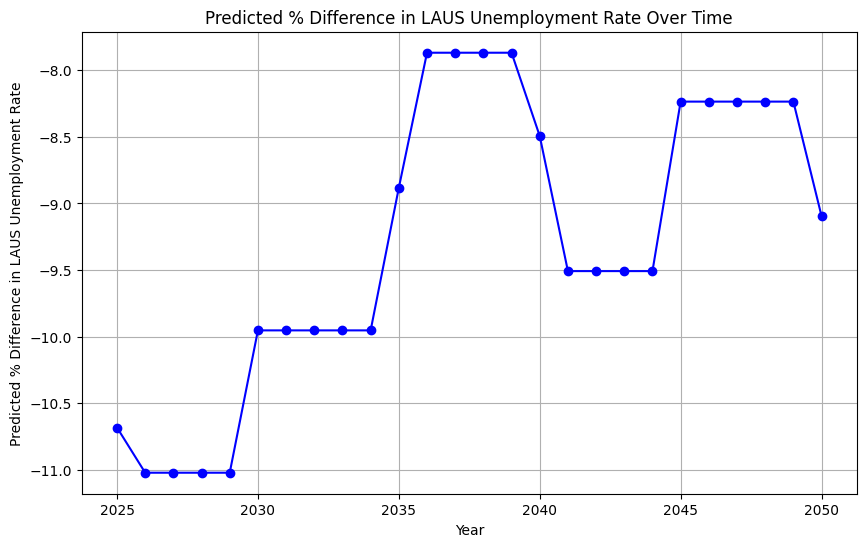

In [76]:
# Plot the predicted unemployment rate
plt.figure(figsize=(10, 6))
plt.plot(future_predictions['year'], future_predictions['pct_diff_laus_unemployment_rate'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Predicted % Difference in LAUS Unemployment Rate')
plt.title('Predicted % Difference in LAUS Unemployment Rate Over Time')
plt.grid(True)
plt.show()

In [ ]:
# # Save the predictions to the output CSV file
# future_predictions.to_csv(EI_PREDS_OUTPUT_PATH, index=False)
# print(f"Predictions saved to {EI_PREDS_OUTPUT_PATH}")

# # %%
